In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.filters import sobel
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_holes, remove_small_objects
import nibabel as nib
import pandas as pd
import cv2

In [3]:
def getFilenameFromID(df, Id):
    filename = "CC"
    for h in df.columns:
        filename+=df[h][Id]+'_'
    filename= filename[:-1]+".nii"
    return filename

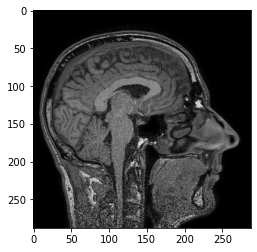

In [134]:
# Carregando imagem aletória e selecionando fatia sagital central

dirname = "../data/raw/"
img_data = pd.read_csv("../data/description.csv", dtype=str)

random_id = np.random.randint(0,high=358)
filename = getFilenameFromID(img_data, random_id)
f = nib.load("../data/raw/"+filename).get_fdata()

x = int(f.shape[0]/2)-2
img = ndi.rotate(f[x,:,:], 90)

img = 255*img/np.max(img)
img = img.astype(np.uint8)

plt.imshow(img, cmap='gray')
plt.show()

## 1° Teste

Vamos selecionar uma imagem aleatória e tentar aplicar o watershed diretamente nela. Não espero bons resultados, mas tenho interesse em vizualizar o que é retornado.

Em todos os testes iniciais irei utilizar a fatia sagital central da imagem como uma aproximação para a fatia sagital central do cérebro. Como os responsáveis por gerar a imagem, geralmente, fazem um bom alinhamento, esta aproximação funciona bem. Futuramente um método melhor poderá ser usado para encontrar o centro do cérebro.

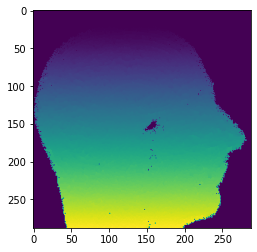

In [135]:
labels = watershed(img, mask=img)
plt.imshow(labels)
plt.show()

# Péssimo resutado

## 2° Teste

Agora gostaria de ver como o watershed se comporta quando antes aplicamentos um filtro Sobel à imagem. Novamente, não espero bons resultados.

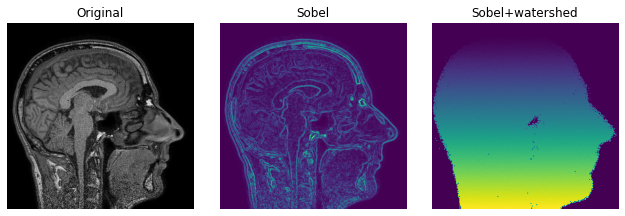

In [136]:
edges = sobel(img)
labels_sobel = watershed(edges, mask=img)

# Plot
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(edges)
ax[1].set_title('Sobel')
ax[2].imshow(labels_sobel)
ax[2].set_title('Sobel+watershed')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

# Em alguns casos há uma melhora notável (o contorno da cabeça do paciente fica bem definido),
# em outros há pouca diferença em relação ao teste 1

## Resultados do 1° e 2° Testes:

Os dois primeiros testes tiveram péssimos resultados, sua função foi apenas sanar um dúvida, mas é interessante notar que em alguns casos podemos delimitar a cabeça do paciente usando Watershed ou Sobel+Watershed.

## 3° Teste

Desta vez tentaremos um processo mais refinado:
 - Aplicar tresholding na imagem
 - Calcular a distância dos pontos selecionados no tresholding para o background
 - Coletar os pontos de máximo e mínimo globais dessas distâncias (obviamente o mínimo é sempre 0)
 - Utilizar os ponstos coletados acima como marcadores para o watershed
 - Aplicar o watershed no negativo das distâncias, usando os marcadores definidos
 - Usar funções morfológicas para retirar pequenos objetos e fechar pequenos buracos

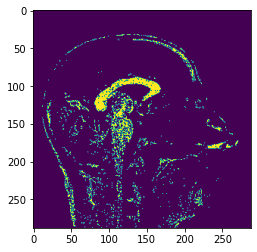

In [140]:
# O tresholding ainda é feito manualmente, pretendo automatizar este passo em seguida

s = np.ones(img.shape, np.int8)
s[img<120]=0
s[img>160]=0
plt.imshow(s)
plt.show()

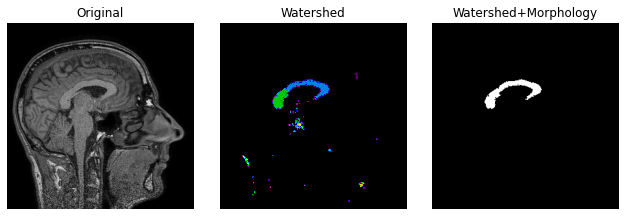

In [143]:
# Calculando a distância até o background
distance = ndi.distance_transform_edt(s)

# Criando os marcadores
mask = np.zeros(distance.shape, dtype=bool) 
mx, mn = np.max(distance), np.min(distance)
mask = (distance==mx)*2+(distance==mn)*1

markers, _ = ndi.label(mask)

# Aplicando o watershed
labels = watershed(-distance, markers)

# Removendo objetos pequenos e buracos
f0 = remove_small_objects(labels)-1
f1 = remove_small_holes(f0, 2)
final = remove_small_objects(f1, min_size=300)

# Plot
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Watershed')
ax[2].imshow(final, cmap=plt.cm.gray)
ax[2].set_title('Watershed+Morphology')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

## Resultados do 3° Teste:

O terceiro teste tem resultados extremamente promissores; selecionar o intervalo para tresholding automaticamente é claramente o próximo o passo para melhorar os resultados. Restringir os testes a apenas uma fabricante e intensidade de campo magnético pode ajudar a tornar os resultados mais consistentes.